In [1]:
import jax
import jax_cosmo as jc
import jax.numpy as np
import pickle

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

In [4]:
res = [] 

for i in range(10):
    res.append(pickle.load(open('results%d.pkl'%i, 'rb')))

In [5]:
ell = res[0]['ell'][2:]
ps = np.stack([r['ps'] for r in res], axis=0).mean(axis=0)[2:]
jac = np.stack([r['jac'] for r in res], axis=0).mean(axis=0)[2:]

In [6]:
cosmo_jax = jc.Planck15()
z = linspace(0,2,100)
pz = zeros_like(z)
pz[50] =1. 
nzs_s=jc.redshift.kde_nz(z, pz, bw=0.05)
nzs = [nzs_s]
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]

# And compute the data vector
cls = jc.angular_cl.angular_cl(cosmo_jax, ell, probes)

mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_jax, ell, probes, sparse=True);

/home/francois/.local/lib/python3.9/site-packages/jax/_src/lax/lax.py:6341: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [7]:
ell

array([ 144.00002,  216.     ,  288.00003,  360.00003,  432.     ,
        504.00003,  576.00006,  648.     ,  720.00006,  792.00006,
        864.     ,  936.00006, 1008.00006, 1080.     ], dtype=float32)

(1e-10, 1e-07)

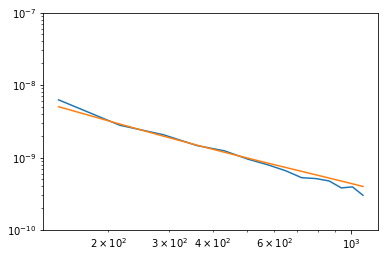

In [8]:
loglog(ell, ps, label='jax')
loglog(ell, mu, label='tf')
ylim(1e-10, 1e-7)

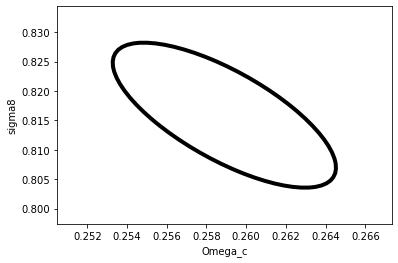

In [9]:
params=np.array([0.2589,0.8159]) 
# Now we can compose the Fisher matrix:
F_2 = jc.sparse.dot(jac.T, jc.sparse.inv(cov), jac)
plot_contours(F_2, params, fill=False,color='black',lw=4);
figsize=(15,15)
xlabel('Omega_c')
ylabel('sigma8');

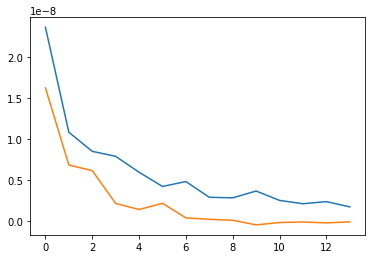

In [10]:
plot(jac[:,0])
plot(jac[:,1])

In [11]:
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell, probes)
  return m.flatten()

In [12]:
jac_mean = jax.jit(jax.jacfwd(mean_fn))

In [13]:
dmu = jac_mean(params)

/home/francois/.local/lib/python3.9/site-packages/jax/_src/lax/lax.py:6341: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Text(0.5, 1.0, 'Jacobian normalized by theory power spectrum')

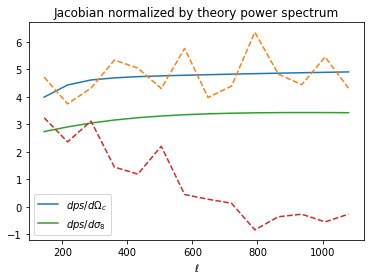

In [14]:
plot(ell, dmu[:,0]/mu,label=r'${d ps}/{d \Omega_c}$')
plot(ell,jac[:,0]/mu,'--')
plot(ell,dmu[:,1]/mu,label=r'${d ps}/{d \sigma_8}$')
plot(ell,jac[:,1]/mu,'--')
xlabel(r'$\ell$')
legend()
title('Jacobian normalized by theory power spectrum')

In [15]:
# Computing a 1D Fisher matrix
F_tf_1D = jc.sparse.dot(dmu[:,0:1].T, jc.sparse.inv(cov), dmu[:,0:1])
F_jax_1D = jc.sparse.dot(jac[:,0:1].T, jc.sparse.inv(cov), jac[:,0:1])

In [17]:
F_tf_1D, F_jax_1D

(DeviceArray([[62673.953]], dtype=float32),
 DeviceArray([[66321.28]], dtype=float32))

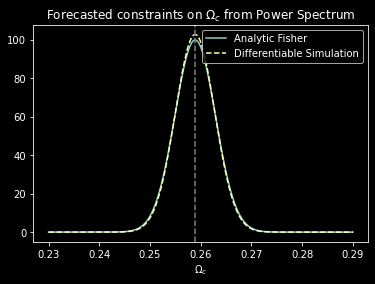

In [66]:
from scipy.stats import norm

# Range of omega_c values to consider
omega_c = linspace(0.23,0.29,256)

with plt.style.context('dark_background'):

    plot(omega_c, norm.pdf(omega_c, 
                          params[0], # Mean of the Gaussian, at the fiducial cosmology
                          scale=np.sqrt(1./F_tf_1D.squeeze())),  label='Analytic Fisher') # Standard deviation of the Gaussian, as the sqrt of the inverse of the Fisher matrix

    plot(omega_c, norm.pdf(omega_c, 
                           params[0], # Mean of the Gaussian, at the fiducial cosmology
                           scale=np.sqrt(1./F_jax_1D.squeeze())), '--',label='Differentiable Simulation') # Standard deviation of the Gaussian,

    axvline(params[0], ls='--', color='gray')
    title('Forecasted constraints on $\Omega_c$ from Power Spectrum')
    xlabel(r'$\Omega_c$')
    legend()
    savefig('forecast_omegac.png',  transparent=True)

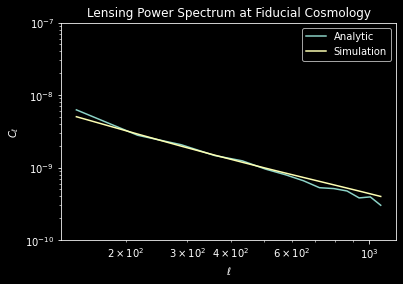

In [74]:
with plt.style.context('dark_background'):
    loglog(ell, ps, label='Analytic')
    loglog(ell, mu, label='Simulation')
    ylim(1e-10, 1e-7)
    title('Lensing Power Spectrum at Fiducial Cosmology')
    legend()
    xlabel(r"$\ell$")
    ylabel(r"$C_\ell$")
    savefig('power_spectrum.png',  transparent=True)

In [139]:
jac[:,1] = dmu[:,1]

In [140]:
F = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)
F_2 = jc.sparse.dot(jac.T, jc.sparse.inv(cov), jac)

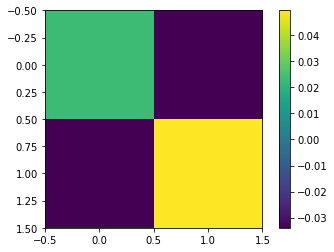

In [141]:
imshow(inv(F)); colorbar()

In [142]:
F

DeviceArray([[62673.95 , 42856.746],
             [42856.746, 29325.82 ]], dtype=float32)

In [143]:
F_2

DeviceArray([[66321.28 , 43691.555],
             [43691.555, 29325.82 ]], dtype=float32)

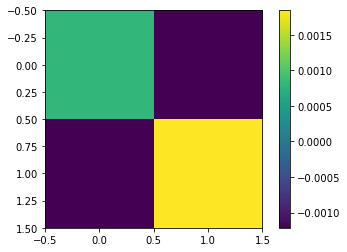

In [144]:
imshow(inv(F_2)); colorbar()

Text(27.0, 0.5, 'sigma8')

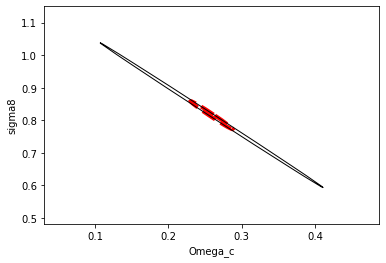

In [145]:
plot_contours(F_2, params, fill=False, color='red', lw=4, linestyle='dashed',)
plot_contours(F, params, fill=False,color='black',lw=1)
xlabel('Omega_c')
ylabel('sigma8')

In [146]:
d = jc.sparse.to_dense(jc.sparse.inv(cov))

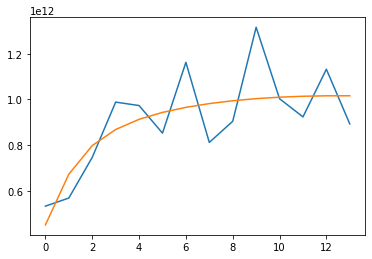

In [147]:
plot(d @ jac[:,0])
plot(d @ dmu[:,0])

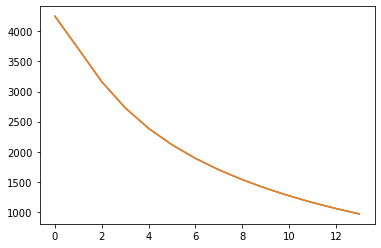

In [148]:
plot(jac[:,1].T * ( d @ jac[:,1]))
plot( dmu[:,1].T * (d  @ dmu[:,1]))

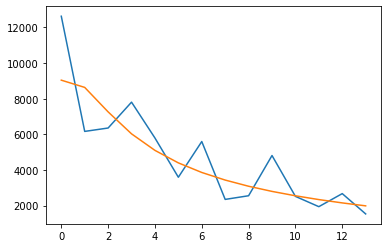

In [149]:
plot(jac[:,0].T * (d  @ jac[:,0]))
plot(dmu[:,0].T * (d  @ dmu[:,0]))